In [0]:
__author__ = "Phillip Lakaschus"
__email__ = "lakaschus@th.physik.uni-frankfurt.de"

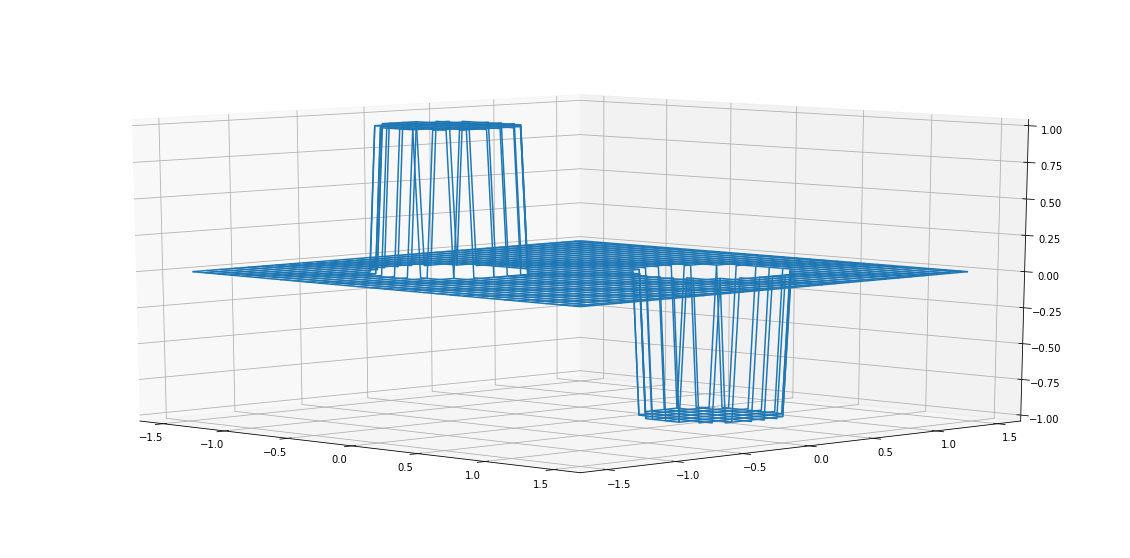

length: (3600,)
[0. 0. 0. ... 0. 0. 0.]


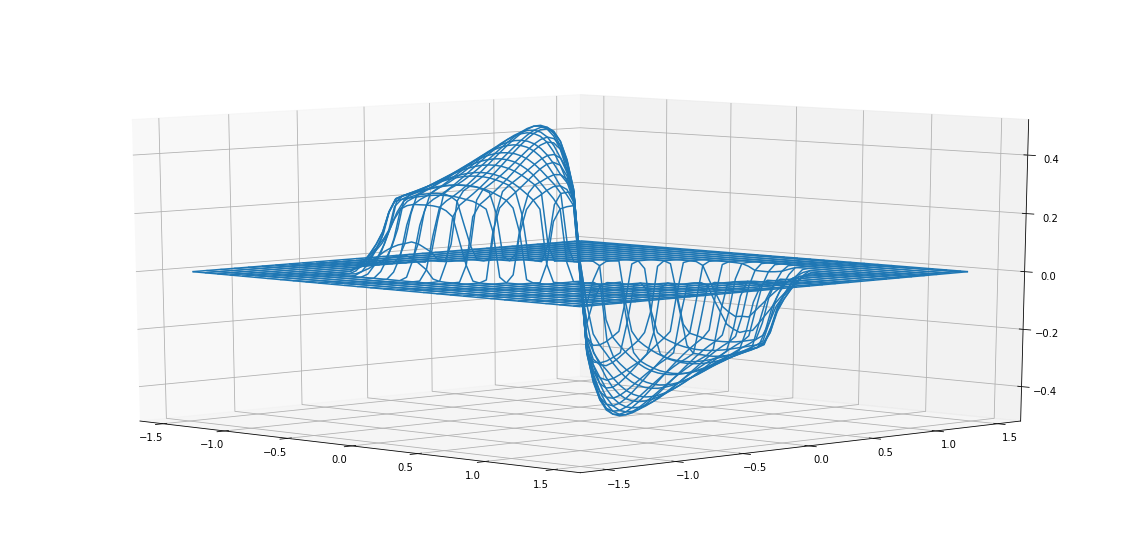

In [0]:
import time
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import integrate
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import RK45

%matplotlib inline 

Nx = 60
x = np.linspace(-1.5, 1.5, Nx+1)

Ny = 60
y = np.linspace(-1.5, 1.5, Ny+1)

N_t = 100
t = np.linspace(0, 0.5, N_t)

xc = 0.5*np.array(x[:-1]+x[1:])
yc = 0.5*np.array(y[:-1]+y[1:])

dx = x[1] - x[0]
dy = y[1] - y[0]

def u0(X, Y):
  return np.heaviside((X-0.5)**2+(Y-0.5)**2-0.4**2, 1) - np.heaviside((X+0.5)**2+(Y+0.5)**2-0.4**2, 1)
  #return X**2 + Y**2

x_ax, y_ax = np.meshgrid(xc, yc)
fig = plt.figure(figsize=(20,10)) 
ax = fig.gca(projection='3d')  
ax.plot_wireframe(x_ax, y_ax, u0(x_ax, y_ax))
ax.view_init(10, -45)
plt.show()

#print(np.array_split(np.squeeze(np.asarray(u0(x_ax, y_ax))).flatten(), 10))
#input()

start = time.time()  

def flux(u):
  return u**2

def glux(u):
  return u**2

def charf(u):
  return 2*u

def charg(u):
  return 2*u

def diffx(u, ux):
  eps = 0.1
  return eps*np.heaviside(abs(u) - 0.25, 1)*ux

def diffy(u, uy):
  eps = 0.1
  return eps*np.heaviside(abs(u) - 0.25, 1)*uy

def minmod(a, b):
  minmod = (np.abs(a) <= np.abs(b)).astype(int)
  minmod2 = (np.abs(b) < np.abs(a)).astype(int)
  return 1/2*(np.sign(a) + np.sign(b))*(minmod*np.abs(a) + minmod2*np.abs(b))
  
def dudt(t, u):
  u = u.reshape(-1, Nx)

  ul_bnd = np.zeros(u[:,0].shape)
  ur_bnd = ul_bnd

  u = np.concatenate((np.array([ul_bnd]).T, np.concatenate((u, np.array([ur_bnd]).T), axis=1)), axis=1)

  ut_bnd = np.zeros(u[0,:].shape)
  ub_bnd = ut_bnd

  u = np.concatenate((np.array([ut_bnd]), np.concatenate((u, np.array([ub_bnd])), axis=0)), axis=0)

  xlimiter = minmod((u[:, 1:-1] - u[:,:-2])/dx, (u[:,2:] - u[:,1:-1])/dx)
  uxLForw = u[:, 0]
  uxLCent = u[:, 1:-1] + dx/2*xlimiter
  
  uxL = np.concatenate((np.array([uxLForw]).T, uxLCent), axis=1)
  
  uxRBack = u[:,-1]
  uxRCent = u[:,1:-1] - dx/2*xlimiter
  uxR = np.concatenate((uxRCent, np.array([uxRBack]).T), axis=1)

  ylimiter = minmod((u[1:-1,:] - u[:-2,:])/dx, (u[2:,:] - u[1:-1,:])/dx)
  uyLForw = u[0,:]
  uyLCent = u[1:-1,:] + dy/2*ylimiter
  uyL = np.concatenate((np.array([uyLForw]), uyLCent), axis=0)

  uyRBack = u[-1,:]
  uyRCent = u[1:-1,:] - dy/2*ylimiter
  uyR = np.concatenate((uyRCent, np.array([uyRBack])), axis=0)

  charxL = charf(uxL)
  charxR = charf(uxR)
  xprop = (np.abs(charxL) >= np.abs(charxR)).astype(int)*np.abs(charxL) \
       + (np.abs(charxL) < np.abs(charxR)).astype(int)*np.abs(charxR)
 
  charyL = charg(uyL)
  charyR = charg(uyR)
  yprop = (np.abs(charyL) >= np.abs(charyR)).astype(int)*np.abs(charyL) \
       + (np.abs(charyL) < np.abs(charyR)).astype(int)*np.abs(charyR)
     
  fu_interface = (flux(uxL) + flux(uxR))/2 - xprop/2*(uxR - uxL)

  gu_interface = (flux(uyL) + flux(uyR))/2 - yprop/2*(uyR - uyL)
  
  Pxp = 1/2*(diffx(u[1:-1, 1:-1], (u[1:-1, 2:] - u[1:-1, 1:-1])/dx) + diffx(u[1:-1, 2:], (u[1:-1, 2:] - u[1:-1, 1:-1])/dx))
  Pxm = 1/2*(diffx(u[1:-1, :-2], (u[1:-1, 1:-1] - u[1:-1, :-2])/dx) + diffx(u[1:-1, 1:-1], (u[1:-1, 1:-1] - u[1:-1, :-2])/dx))
  Pyp = 1/2*(diffy(u[1:-1, 1:-1], (u[2:, 1:-1] - u[1:-1, 1:-1])/dy) + diffy(u[2:, 1:-1], (u[2:, 1:-1] - u[1:-1, 1:-1])/dy))
  Pym = 1/2*(diffy(u[:-2, 1:-1], (u[1:-1, 1:-1] - u[:-2, 1:-1])/dy) + diffy(u[1:-1, 1:-1], (u[1:-1, 1:-1] - u[:-2,1:-1])/dy))

  dudt =  (fu_interface[1:-1, :-1] - fu_interface[1:-1, 1:])/dx + (gu_interface[:-1, 1:-1] - gu_interface[1:, 1:-1])/dy + (Pxp - Pxm)/dx + (Pyp - Pym)/dy
  #print("time: ", t)
  return np.squeeze(dudt).flatten()

def construct_potential(x, u):
    return integrate.cumtrapz(u, x, initial=0)
  
def solution():
    u0_vec = np.squeeze(np.asarray(u0(x_ax, y_ax))).flatten()
    print("length:", u0_vec.shape)
    return odeint(dudt, u0_vec, t, mxstep=10000, rtol= 1e-9, atol=1e-9)
#scipy.integrate.RK45(fun, t0, y0, t_bound, max_step=inf, rtol=0.001, atol=1e-06, vectorized=False, first_step=None, **extraneous)
def solution():
    u0_vec = np.squeeze(np.asarray(u0(x_ax, y_ax))).flatten()
    print("length:", u0_vec.shape)
    return solve_ivp(dudt, (t[0], t[-1]), u0_vec, method='RK45', rtol=0.001, atol=1e-06, vectorized=False, first_step=None)

sol = solution()
print(sol.y.T[-1])

fig = plt.figure(figsize=(20,10)) 
ax = fig.gca(projection='3d')  
ax.plot_wireframe(x_ax, y_ax, sol.y.T[-1].reshape(-1, Nx))
ax.view_init(10, -45)
plt.show()
    
#print(sol[-1])